## Filtering Audio Signals

Filtering signals is a very common task in acoustics signal processing and pyfar provides three different `filter classes` for storing and applying filters

- **FIR Filter:** Finite Impulse Response (FIR) filters are non-recursive filters. FIR filters are very flexible and can have arbitrary magnitude and phase responses. One example for an FIR filter is an impulse response.
- **IIR Filter:** Infinite Impulse Response (IIR) filters are recursive filters. They can achieve steeper filter slopes than FIR filters of the same order but are less flexible with respect to the phase response.
- **SOS Filter:** Second Order Section (SOS) filters are cascaded 2nd order recursive filters. They are often more robust against numerical errors than IIR filters of the same order and are thus the most common way of realizing IIR filters.

From a users perspective the type of filter does not matter too much, because filtering works exactly the same for all three filter classes. The following examples show how to create and apply filter objects to audio signals using a simple IIR filter.

In [1]:
import pyfar as pf
import numpy as np
%matplotlib inline

## Creating a filter 

A filter object is initialized with the filter coefficients and a sampling rate. For example an IIR filter requires a set of b-coefficients and a-coefficients, like this simple comb filter example

In [2]:
# design filter coefficients
b = [1, 0, 0]
a = [1, 0, .95]
coefficients = np.stack((b, a), 0)

# create filter object
comb_filter = pf.FilterIIR(coefficients, 44100)

For convenience a summary of the filter can be obtained if it is printed

In [3]:
print(comb_filter)

2nd order IIR filter with 1 channel @ 44100 Hz sampling rate


### Filtering a signal

To filter an audio signal, pass it to the filter's process function. As a simple example, lets filter an impulse signal and plot the result to inspect the filter

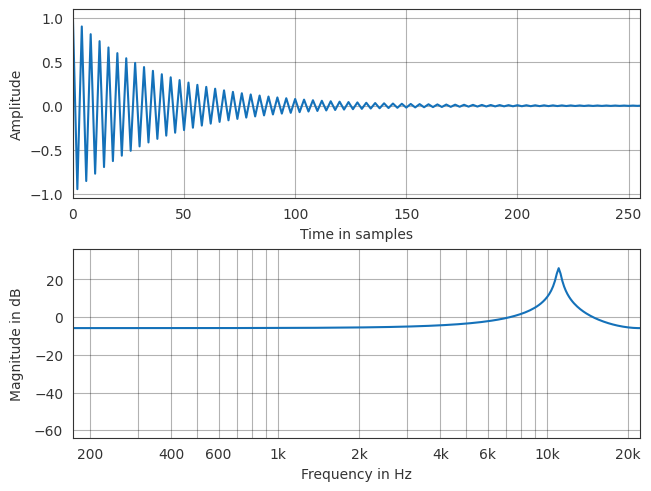

In [4]:
input = pf.signals.impulse(256)
output = comb_filter.process(input)

ax = pf.plot.time_freq(output, unit='samples')

## Blockwise filtering

For the above, output will be the same no matter how often `process` is called. This default behavior is often desired. In some cases, like block-wise filtering of a signal, the filter object can track the state of the filter. By default, the filter state is set to `None`, but a different state can be set at any time. This requires the `cshape` of the signal that will be filtered and the kind of state. 

In [5]:
comb_filter.init_state(input.cshape, 'zeros')

Now, the same result as above can be obtained in blockwise processing

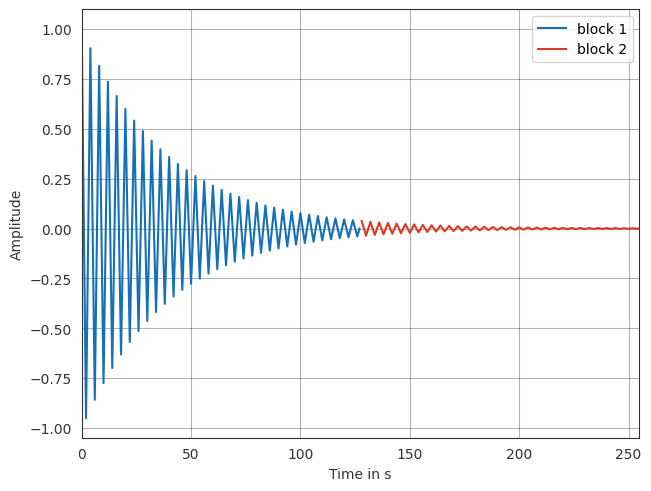

In [6]:
block_1 = comb_filter.process(input[:, :128])  # compute first 128 samples
block_2 = comb_filter.process(input[:, 128:])  # compute last 128 samples

# plotting the time signals of both blocks
ax = pf.plot.time(block_1, unit='samples', label='block 1')
pf.plot.time(pf.TimeData(block_2.time, np.arange(128)+128), label='block 2')
ax.legend()

## Time-variant block wise filtering

If tracking the state of a filter object is enabled as in the example above, a time-variant filter can be realized by changing the filter coefficients between calling the `pocess` function. Note that this however, only works if the order of the filter does not change.

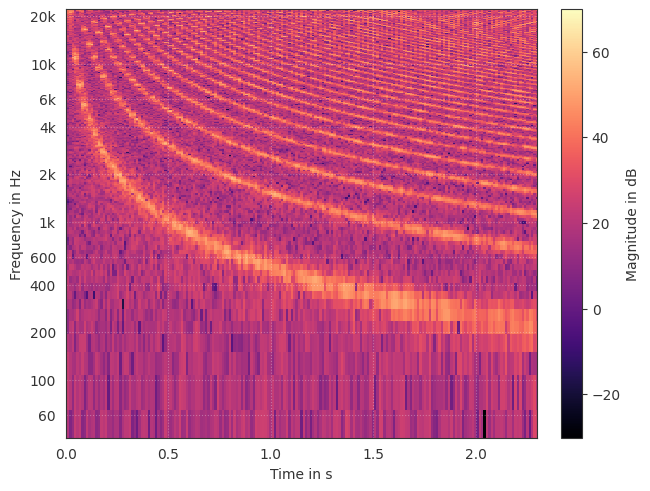

In [7]:
# design initial filter coefficients
order = 100
b = np.zeros(order + 1)
b[0] = 1

# create filter object
comb_filter = pf.FilterIIR(np.stack((b, b), 0), 44100)
comb_filter.init_state(input.cshape, 'zeros')

# design input signal
block_size = 1024
input = pf.signals.noise(
    order * block_size, sampling_rate=comb_filter.sampling_rate)

# initialize output signal
output = pf.Signal(np.zeros(input.n_samples), input.sampling_rate)

for nn in range(1, order + 1):

    # update filter coefficients: increase delay of recursive filter part by
    # one in each block
    comb_filter.coefficients[:, 1, nn] = .95
    if nn > 1:
        comb_filter.coefficients[:, 1, nn-1] = 0

    # filter current block
    block = comb_filter.process(input[:, nn*block_size:(nn+1)*block_size])

    # write block to output signal
    output.time[:, nn*block_size:(nn+1)*block_size] = block.time

_ = pf.plot.spectrogram(output, window_length=block_size, freq_scale='log')


The plot shows that increasing the delay of the in the recursive filter coefficients decreases the resonance frequency seen in the earlier plots and that new resonance frequencies start to emerge at frequencies that are multiples of the first resonance.

If you have `sounddevice` installed, you can listen to the output using

```python
import sounddevice as sd
sd.play(pf.dsp.normalize(output).time.T, output.sampling_rate, blocking=True)
```

### Follow up

Note that pyfar offers a variety of common filter functions including filter banks, bell, and shelve filters, as well as classic filter types such as low-passes and band-passes. Check out the `filter type` examples for more information.